
PART 3: CORRUPT IMAGE DETECTION
Using PCA with 90 components
Expected corrupted images: 89 out of 405

Threshold (based on 98th percentile): 1624.90
Training error range: 138.76 - 2393.20
Training error mean: 834.25 ± 350.29

✓ Detected 96 corrupted images
Detection rate: 107.9% (if all 89 are found)


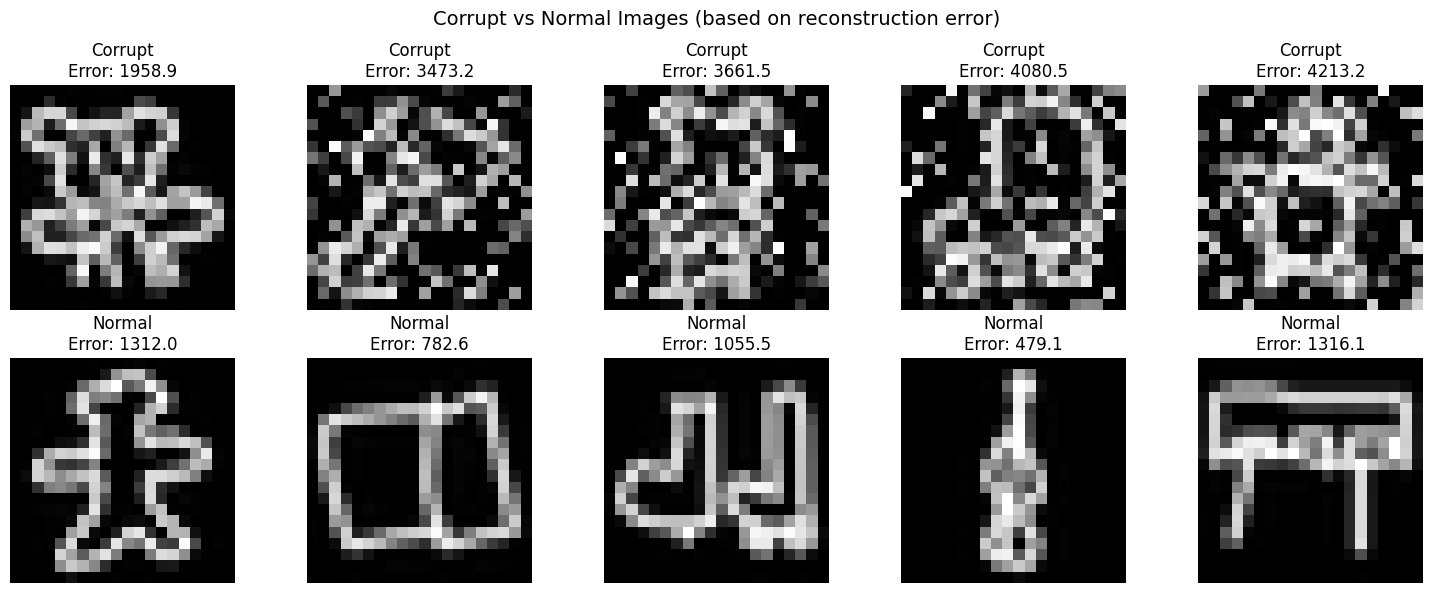

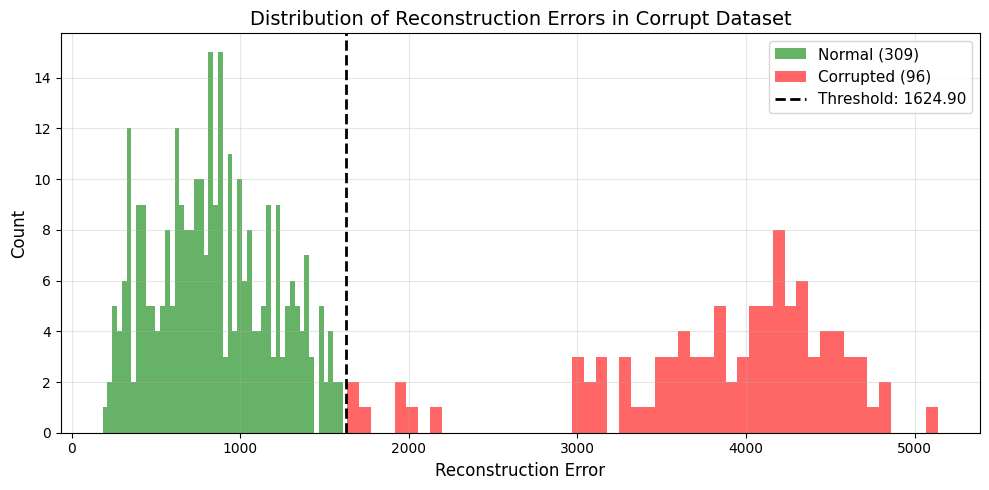

Results saved to 'part3_corrupt_detection.npz'


In [ ]:
# PART 3: CORRUPT IMAGE DETECTION
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def detect_corrupt_images(X_train, X_corrupt, n_components=50, percentile=95):
    print("\n" + "="*60)
    print("PART 3: CORRUPT IMAGE DETECTION")
    print("="*60)
    print(f"Using PCA with {n_components} components")
    print(f"Expected corrupted images: 89 out of {len(X_corrupt)}")
    
    # 1. Fit PCA on training data (normal images only)
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X_train)
    
    # 2. Calculate reconstruction error for training data to establish baseline
    X_train_transformed = pca.transform(X_train)
    X_train_reconstructed = pca.inverse_transform(X_train_transformed)
    train_errors = np.mean((X_train - X_train_reconstructed) ** 2, axis=1)
    
    # 3. Set threshold based on training data distribution
    threshold = np.percentile(train_errors, percentile)
    print(f"\nThreshold (based on {percentile}th percentile): {threshold:.2f}")
    print(f"Training error range: {train_errors.min():.2f} - {train_errors.max():.2f}")
    print(f"Training error mean: {train_errors.mean():.2f} ± {train_errors.std():.2f}")
    
    # 4. Calculate reconstruction error for corrupt dataset
    X_corrupt_transformed = pca.transform(X_corrupt)
    X_corrupt_reconstructed = pca.inverse_transform(X_corrupt_transformed)
    corrupt_errors = np.mean((X_corrupt - X_corrupt_reconstructed) ** 2, axis=1)
    
    # 5. Identify corrupted images (those above threshold)
    is_corrupted = corrupt_errors > threshold
    n_detected = np.sum(is_corrupted)
    
    print(f"\n✓ Detected {n_detected} corrupted images")
    print(f"Detection rate: {100*n_detected/89:.1f}% (if all 89 are found)")
    
    return is_corrupted, corrupt_errors, threshold, pca

def visualize_corrupt_detection(X_corrupt, is_corrupted, corrupt_errors, threshold):
    # 1. Show examples of detected corrupted images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    corrupted_indices = np.where(is_corrupted)[0]
    normal_indices = np.where(~is_corrupted)[0]
    
    # Top row: detected corrupted images
    for i in range(5):
        if i < len(corrupted_indices):
            idx = corrupted_indices[i]
            axes[0, i].imshow(X_corrupt[idx].reshape(20, 20), cmap='gray', vmin=0, vmax=255)
            axes[0, i].set_title(f'Corrupt\nError: {corrupt_errors[idx]:.1f}')
        axes[0, i].axis('off')
    
    # Bottom row: normal images
    for i in range(5):
        if i < len(normal_indices):
            idx = normal_indices[i]
            axes[1, i].imshow(X_corrupt[idx].reshape(20, 20), cmap='gray', vmin=0, vmax=255)
            axes[1, i].set_title(f'Normal\nError: {corrupt_errors[idx]:.1f}')
        axes[1, i].axis('off')
    
    plt.suptitle('Corrupt vs Normal Images (based on reconstruction error)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 2. Plot histogram of reconstruction errors
    plt.figure(figsize=(10, 5))
    
    corrupted_errors = corrupt_errors[is_corrupted]
    normal_errors = corrupt_errors[~is_corrupted]
    
    plt.hist(normal_errors, bins=50, alpha=0.6, label=f'Normal ({len(normal_errors)})', color='green')
    plt.hist(corrupted_errors, bins=50, alpha=0.6, label=f'Corrupted ({len(corrupted_errors)})', color='red')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2f}')
    
    plt.xlabel('Reconstruction Error', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Distribution of Reconstruction Errors in Corrupt Dataset', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main execution for Part 3
if __name__ == "__main__":
    # Load datasets
    dataset = np.load("dataset.npz")
    X_train, y_train = dataset["X"], dataset["y"]
    
    dataset_corrupt = np.load("dataset_corrupted.npz")
    X_corrupt = dataset_corrupt["X"]
    
    # Detect corrupted images
    is_corrupted, corrupt_errors, threshold, pca = detect_corrupt_images(
        X_train, X_corrupt, 
        n_components=90,  # Can tune this (try 30-100)
        percentile=98      # Can tune this (try 90-98)
    )
    
    # Visualize results
    visualize_corrupt_detection(X_corrupt, is_corrupted, corrupt_errors, threshold)
    
    # Save results for report
    results = {
        'is_corrupted': is_corrupted,
        'reconstruction_errors': corrupt_errors,
        'threshold': threshold,
        'n_detected': np.sum(is_corrupted)
    }
    np.savez('part3_corrupt_detection.npz', **results)
    print("Results saved to 'part3_corrupt_detection.npz'")